In [ ]:
# only run this on Google Colab
!pip install geopandas
!pip install folium

In [2]:
import pandas as pd
import seaborn as sns
import folium
import numpy as np
import matplotlib.pyplot as plt

  Using cached geopandas-0.10.2-py2.py3-none-any.whl (1.0 MB)
  Using cached Fiona-1.8.21.tar.gz (1.0 MB)
  Using cached Fiona-1.8.20.tar.gz (1.3 MB)
  Using cached Fiona-1.8.19.tar.gz (1.3 MB)
  Using cached Fiona-1.8.18.tar.gz (1.3 MB)
  Using cached Fiona-1.8.17.tar.gz (1.3 MB)
  Using cached Fiona-1.8.16.tar.gz (1.3 MB)
  Using cached Fiona-1.8.15.tar.gz (1.3 MB)
  Using cached Fiona-1.8.14.tar.gz (1.3 MB)
  Using cached Fiona-1.8.13.post1.tar.gz (1.2 MB)
  Using cached Fiona-1.8.13.tar.gz (1.2 MB)
  Using cached Fiona-1.8.12.tar.gz (1.2 MB)
  Using cached Fiona-1.8.11.tar.gz (1.2 MB)
  Using cached Fiona-1.8.10.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.post2.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.post1.tar.gz (1.2 MB)
  Using cached Fiona-1.8.9.tar.gz (1.2 MB)
  Using cached Fiona-1.8.8.tar.gz (1.7 MB)
  Using cached Fiona-1.8.7.tar.gz (1.7 MB)
  Using cached Fiona-1.8.6.tar.gz (1.7 MB)
  Using cached Fiona-1.8.5.tar.gz (1.7 MB)
  Using cached Fiona-1.8.4.tar.gz (1.1 MB)
  Us

    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\Maciek\__repos\BESTHL-AI\venv\Scripts\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Maciek\\AppData\\Local\\Temp\\pip-install-jlvrs1p2\\fiona_d906a63cd0ff400ba6b4c0b8e2af9a95\\setup.py'"'"'; __file__='"'"'C:\\Users\\Maciek\\AppData\\Local\\Temp\\pip-install-jlvrs1p2\\fiona_d906a63cd0ff400ba6b4c0b8e2af9a95\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\Maciek\AppData\Local\Temp\pip-pip-egg-info-_yaq93nv'
         cwd: C:\Users\Maciek\AppData\Local\Temp\pip-install-jlvrs1p2\fiona_d906a63cd0ff400ba6b4c0b8e2af9a95\
    Complete output (1 lines):
    A GDAL API version must be specified. Provide a path to gdal-config using 

# Load

In [3]:
main_df = pd.read_csv('https://raw.githubusercontent.com/Dynovski/BESTHL-AI/main/train_data.csv?token=GHSAT0AAAAAABTLWN7I6LMAI3BK5ZSQSE7WYSZQ4DA', error_bad_lines=False)
print(main_df.head())

C:\Users\Maciek\AppData\Local\Temp\ipykernel_10568\363779577.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  main_df = pd.read_csv('https://raw.githubusercontent.com/Dynovski/BESTHL-AI/main/train_data.csv?token=GHSAT0AAAAAABTLWN7I6LMAI3BK5ZSQSE7WYSZQ4DA', error_bad_lines=False)


         BBLE  BORO  BLOCK   LOT EASEMENT                OWNER BLDGCL  \
0  1001791101     1    179  1101      NaN  155 FRANKLIN ST LLC     RK   
1  1000163436     1     16  3436      NaN         BROADLAR LLC     R4   
2  1000761255     1     76  1255      NaN         HAM, RICHARD     R4   
3  1000161179     1     16  1179      NaN        SHIM, HAE JIN     R4   
4  1001751526     1    175  1526      NaN        BRIT GIRL LLC     R4   

  TAXCLASS  LTFRONT  LTDEPTH  ... VALTYPE    Borough   Latitude  Longitude  \
0        4        0        0  ...   AC-TR  MANHATTAN  40.719232 -74.008095   
1        2        0        0  ...   AC-TR  MANHATTAN  40.709270 -74.016487   
2        2        0        0  ...   AC-TR  MANHATTAN  40.708006 -74.006164   
3        2        0        0  ...   AC-TR  MANHATTAN  40.709506 -74.018002   
4        2        0        0  ...   AC-TR  MANHATTAN  40.718024 -74.003903   

   Community Board  Council District  Census Tract        BIN  \
0            101.0         

b'Skipping line 5856: expected 40 fields, saw 70\nSkipping line 7939: expected 40 fields, saw 49\n'


In [4]:
processed_df = pd.read_csv('processed.csv')
processed_df.head()

,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,BLDFRONT,BLDDEPTH,...,EXCD1_5112.0category,EXCD1_5113.0category,EXCD1_5114.0category,EXCD1_5118.0category,EXCD1_5130.0category,EXCD1_6800.0category,EXCD1_nancategory,EXCD1_other,LTAREA,BLDAREA
0,0.418722,0.222695,0.679674,1.037423,1.328547,1.760273,0.750434,0.788020,0.401337,0.262802,...,0,0,0,0,0,0,1,0,0.093247,0.105472
1,0.418722,0.222695,2.144616,-0.205828,0.360384,0.505832,-0.126706,0.336695,0.401337,0.262802,...,0,0,0,0,0,1,0,0,0.093247,0.105472
2,0.418722,0.222695,2.235519,-0.374268,0.145795,0.335874,0.750434,0.788020,2.433775,2.747254,...,0,0,0,0,0,0,1,0,0.093247,6.686198
3,0.418722,0.222695,2.319422,-0.344722,0.256552,0.365690,-0.230537,0.216101,0.401337,0.262802,...,0,0,0,0,0,1,0,0,0.093247,0.105472
4,0.418722,0.222695,1.936328,0.178492,0.090309,0.893611,0.750434,0.788020,0.848440,2.105427,...,0,0,0,0,0,0,1,0,0.093247,1.786328


# Basic stuff

In [5]:
main_df.shape

(11946, 40)

In [6]:
main_df.columns

Index(['BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'POSTCODE', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'Borough', 'Latitude',
       'Longitude', 'Community Board', 'Council District', 'Census Tract',
       'BIN', 'NTA', 'New Georeferenced Column'],
      dtype='object')

In [7]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   BBLE                      11946 non-null  object 
 1   BORO                      11946 non-null  int64  
 2   BLOCK                     11946 non-null  int64  
 3   LOT                       11946 non-null  int64  
 4   EASEMENT                  126 non-null    object 
 5   OWNER                     11672 non-null  object 
 6   BLDGCL                    11946 non-null  object 
 7   TAXCLASS                  11946 non-null  object 
 8   LTFRONT                   11946 non-null  int64  
 9   LTDEPTH                   11946 non-null  int64  
 10  EXT                       2982 non-null   object 
 11  STORIES                   11235 non-null  float64
 12  FULLVAL                   11946 non-null  int64  
 13  AVLAND                    11946 non-null  int64  
 14  AVTOT 

In [8]:
main_df.describe()

,BORO,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,Latitude,Longitude,Community Board,Council District,Census Tract,BIN
count,11946.000000,11946.000000,11946.000000,11946.000000,11946.000000,11235.000000,1.194600e+04,1.194600e+04,1.194600e+04,1.194600e+04,...,3.765000e+03,1.155000e+03,1.784000e+03,768.000000,11512.000000,11512.000000,11512.000000,11512.000000,11512.000000,1.144400e+04
mean,3.331157,2824.917211,641.920392,36.532312,81.400301,5.727913,1.335496e+06,9.346050e+04,4.107890e+05,4.300110e+04,...,1.090140e+06,4.179602e+05,1.008948e+06,1291.614583,40.693080,-73.996417,336.457696,29.532922,24433.697446,3.847363e+06
std,1.507452,2901.164736,1226.806277,70.695412,95.231570,9.522701,9.803228e+06,1.339795e+06,4.408330e+06,1.129310e+06,...,6.962595e+06,3.584349e+06,6.233739e+06,994.923358,0.085124,0.139458,150.464025,18.094030,43372.796923,4.705192e+07
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.500000e+01,2.100000e+01,7.500000e+01,1015.000000,40.572265,-74.201789,101.000000,1.000000,1.000000,1.000000e+06
25%,2.000000,738.250000,32.000000,8.000000,24.000000,2.000000,3.070000e+05,4.777250e+03,2.066400e+04,0.000000e+00,...,6.935900e+04,3.888000e+03,2.647100e+04,1017.000000,40.614751,-74.151872,202.000000,16.000000,59.000000,2.006817e+06
50%,4.000000,2155.000000,83.000000,24.000000,100.000000,2.000000,4.980000e+05,9.650000e+03,3.085000e+04,0.000000e+00,...,1.484500e+05,1.820300e+04,7.931600e+04,1017.000000,40.690018,-74.004330,409.000000,32.000000,381.000000,4.171550e+06
75%,5.000000,2694.000000,1042.000000,40.000000,100.000000,4.500000,7.140000e+05,1.694925e+04,9.672600e+04,1.470000e+03,...,4.081490e+05,4.915200e+04,2.106495e+05,1017.000000,40.738557,-73.908092,502.000000,50.000000,29103.000000,5.034382e+06
max,5.000000,9169.000000,9108.000000,2458.000000,2800.000000,70.000000,4.620010e+08,1.044454e+08,2.079004e+08,1.044454e+08,...,1.762926e+08,1.044454e+08,1.575328e+08,5130.000000,40.912536,-73.700779,502.000000,51.000000,157903.000000,5.034204e+09


In [9]:
main_df['POSTCODE'].value_counts()

10314.0    3309
11421.0     697
10013.0     545
11201.0     440
11220.0     407
11231.0     382
11426.0     373
10303.0     351
11362.0     344
10456.0     311
11004.0     305
10280.0     296
11232.0     244
10007.0     231
10455.0     227
10005.0     226
10459.0     225
10038.0     211
10454.0     182
10451.0     169
11215.0     169
11416.0     160
10453.0     159
11217.0     156
10452.0     150
10306.0     134
10474.0     127
11001.0     126
10004.0     120
10033.0     112
10471.0     111
10006.0     106
10034.0      93
10457.0      92
10463.0      86
10040.0      69
11040.0      68
10282.0      19
11218.0      17
10305.0       8
11238.0       7
10002.0       5
10041.0       4
10302.0       4
10003.0       4
10012.0       3
10009.0       3
10014.0       2
10464.0       1
11417.0       1
10011.0       1
10045.0       1
10312.0       1
Name: POSTCODE, dtype: int64

<AxesSubplot:ylabel='FULLVAL'>

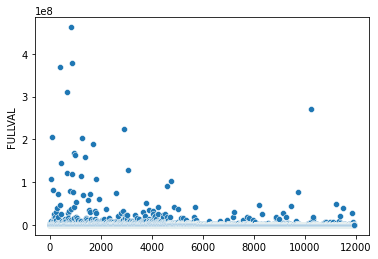

In [10]:
sns.scatterplot(data=main_df, x=main_df.index, y=main_df["FULLVAL"])

In [ ]:
type(main_df['TAXCLASS'][0])

In [ ]:
main_df['TAXCLASS'].head(19)

In [ ]:
sns.catplot(data=main_df, x=main_df.index, y=main_df["TAXCLASS"])

# Map

In [11]:
main_df['Latitude'].value_counts().head(30)

40.708809    49
40.581202    46
40.705486    43
40.708006    41
40.707731    41
40.706531    38
40.707665    36
40.693398    34
40.587767    34
40.705209    34
40.707977    32
40.709270    32
40.707060    29
40.587652    28
40.709311    27
40.709506    24
40.709448    24
40.716863    23
40.706171    22
40.715757    22
40.706358    22
40.577988    21
40.717906    20
40.712987    20
40.708005    19
40.708037    18
40.713843    18
40.708114    18
40.691186    18
40.709097    17
Name: Latitude, dtype: int64

In [12]:
main_df['Longitude'].value_counts().head(30)

-74.016116    49
-74.162664    46
-74.007874    43
-74.006164    41
-74.013706    41
-74.011022    38
-73.999488    37
-74.010135    36
-74.165557    34
-74.009998    34
-74.016487    32
-74.016729    32
-74.016519    29
-74.165359    28
-74.017764    27
-74.018002    24
-74.017252    24
-74.012207    23
-74.016862    22
-74.011493    22
-74.016151    22
-74.162923    21
-74.008686    20
-74.003135    20
-74.015531    19
-74.017656    18
-74.013790    18
-74.017630    18
-73.990019    18
-74.006886    17
Name: Longitude, dtype: int64

In [13]:
# Watch out! sampling resets index
map_df = main_df[main_df['Latitude'].notna()].sample(frac=1).reset_index(drop=True)

# using too big location_number param results in slow map 
location_number = 1000

map_df = map_df[map_df['Longitude'].notna()].head(location_number)
print(map_df.shape)

(1000, 40)


In [14]:
map_df['Latitude'].loc[0]
type(map_df['Latitude'].loc[0])

numpy.float64

In [15]:
map_df['Longitude'].loc[0]
type(map_df['Latitude'].loc[0])

numpy.float64

In [16]:
map_full = folium.Map(location=[40.719232, -74.00809], zoom_start=9)

In [17]:
for index, _ in map_df.iterrows():
    folium.Marker([map_df['Latitude'].loc[index], map_df['Longitude'].loc[index]]).add_to(map_full)

In [18]:
map_full

## Separating clusters

### k-means

In [19]:
from scipy.cluster.vq import kmeans2, whiten

In [29]:
map_kmeans = folium.Map(location=[40.719232, -74.00809], zoom_start=9)

In [30]:
coordinates_kmeans = [[map_df['Latitude'].loc[index], map_df['Longitude'].loc[index]] for index, _ in map_df.iterrows()]
coordinates_kmeans = np.array(coordinates_kmeans)
print(type(coordinates_kmeans))
print(len(coordinates_kmeans))
print(coordinates_kmeans[19])
print(type(coordinates_kmeans[19]))

<class 'numpy.ndarray'>
1000
[ 40.619718 -74.166306]
<class 'numpy.ndarray'>


In [31]:
# non-pythonic :-(
num_clusters_kmeans = set(y)

for idx, place in enumerate(coordinates_kmeans):
    if y[idx] == 0:
        folium.Marker([place[0], place[1]], icon=folium.Icon(color="purple")).add_to(map_kmeans)
    if y[idx] == 1:
        folium.Marker([place[0], place[1]], icon=folium.Icon(color="gray")).add_to(map_kmeans)
    if y[idx] == 2:
        folium.Marker([place[0], place[1]], icon=folium.Icon(color="green")).add_to(map_kmeans)
    if y[idx] == 3:
        folium.Marker([place[0], place[1]], icon=folium.Icon(color="blue")).add_to(map_kmeans)
    if y[idx] == 4:
        folium.Marker([place[0], place[1]], icon=folium.Icon(color="red")).add_to(map_kmeans)

[ 40.689229 -73.993362]


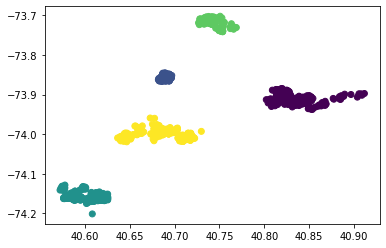

In [24]:
x, y = kmeans2(whiten(coordinates_kmeans), 5, iter = 20)  
# print(y)
print(coordinates_kmeans[0])
plt.scatter(coordinates_kmeans[:,0], coordinates_kmeans[:,1], c=y)
plt.show()

In [32]:
map_kmeans

### DBSCAN

In [33]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [34]:
coordinates_dbscan = map_df[['Latitude', 'Longitude']].to_numpy()

In [35]:
kms_per_radian = 6371.0088
epsilon = 1.7 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coordinates_dbscan))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coordinates_dbscan[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 6


In [36]:
print(clusters.shape)
print(clusters.info())
print(type(clusters[2]))
print(len(clusters[2]))

(6,)
<class 'pandas.core.series.Series'>
RangeIndex: 6 entries, 0 to 5
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
6 non-null      object
dtypes: object(1)
memory usage: 176.0+ bytes
None
<class 'numpy.ndarray'>
327


In [37]:
map_dbscan = folium.Map(location=[40.719232, -74.00809], zoom_start=9)

In [38]:
for place in clusters[0]:
    folium.Marker([place[0], place[1]], icon=folium.Icon(color="orange")).add_to(map_dbscan)

In [39]:
for place in clusters[1]:
    folium.Marker([place[0], place[1]], icon=folium.Icon(color="blue")).add_to(map_dbscan)

In [40]:
for place in clusters[2]:
    folium.Marker([place[0], place[1]], icon=folium.Icon(color="purple")).add_to(map_dbscan)

In [41]:
for place in clusters[3]:
    folium.Marker([place[0], place[1]], icon=folium.Icon(color="green")).add_to(map_dbscan)

In [42]:
for place in clusters[4]:
    folium.Marker([place[0], place[1]], icon=folium.Icon(color="red")).add_to(map_dbscan)

In [43]:
for place in clusters[5]:
    folium.Marker([place[0], place[1]], icon=folium.Icon(color="gray")).add_to(map_dbscan)

In [44]:
map_dbscan

# Augment

In [ ]:
augmented_df = processed_df

In [ ]:
augmented_df.loc[(augmented_df['Latitude'] <= 90) & (augmented_df['Latitude'] >= -90)]

In [ ]:
augmented_df.loc[(augmented_df['Longitude'] <= 180) & (augmented_df['Longitude'] >= -180)]

In [ ]:
augmented_df['1-closest neighbour value'] = 0
augmented_df['2-closest neighbour value'] = 0
augmented_df['3-closest neighbour value'] = 0
augmented_df['4-closest neighbour value'] = 0
augmented_df['5-closest neighbour value'] = 0

augmented_df[['1-closest neighbour value', 
              '2-closest neighbour value', 
              '3-closest neighbour value', 
              '4-closest neighbour value', 
              '5-closest neighbour value']].head()

In [ ]:
from sklearn.neighbors import BallTree

In [ ]:
print(augmented_df[['Latitude', 'Longitude']].values.shape)

In [ ]:
tree = BallTree(np.deg2rad(augmented_df[['Latitude', 'Longitude']].values), metric='haversine')

In [ ]:
query_lats = augmented_df['Latitude']
query_lons = augmented_df['Longitude']
print(query_lats.shape)
print(query_lons.shape)
print(query_lats.head())
print(query_lons.head())

In [ ]:
# Find closest city in reference dataset for each in df_other
# use k = 6 for 5 closest neighbors + self
distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k = 6)
# print(len(distances))
# print(len(indices))

r_km = 6371 # multiplier to convert to km (from unit distance)
for name, d, ind in zip(augmented_df.index, distances, indices):
    print(f"Property with index {name} closest matches:")
    for i, index in enumerate(ind):
        print(f"\t{index} with distance {d[i]*r_km:.4f} km")

In [ ]:
distances, indices = tree.query(np.deg2rad(np.c_[query_lats, query_lons]), k = 6)
helper_df = augmented_df['FULLVAL']

r_km = 6371 # multiplier to convert to km (from unit distance)
for work_index, d, ind in zip(augmented_df.index, distances, indices):
    for i, index in enumerate(ind):
        if i:
            augmented_df.loc[work_index, f'{i}-closest neighbour value'] = helper_df.loc[index]

In [ ]:
augmented_df[['1-closest neighbour value', 
              '2-closest neighbour value', 
              '3-closest neighbour value', 
              '4-closest neighbour value', 
              '5-closest neighbour value']].head()

In [ ]:
print(augmented_df.shape)
print(augmented_df.columns)

In [ ]:
augmented_df.to_csv('./augmented.csv', index=False)

In [ ]:
test_df = pd.read_csv('augmented.csv')
print(test_df.shape)
print(test_df.columns)